In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [2]:

K_B = 1.38e-23 
H_PLANCK = 6.626e-34  
T = 298.15  
A = 1e9  
G_values = [0, -0.33, 1.37, 3.2, 4.92]
Ea0 = 0.26 
beta = 0.5
pe_g = 1
H2O_g = 1
O2_g = 2.34e-5
F = 96485.33212 


In [3]:
def calculate_modified_G(G_values, V):
    
    modified_G_values = [G - i * V for i, G in enumerate(G_values)]
  
    modified_G_values[0] = G_values[0]
    return modified_G_values

In [4]:
def calculate_Ea(Ea0, beta, delta_G):
    if -beta * delta_G > Ea0:
        return 0.224
    elif (1 - beta) * delta_G > Ea0:
        return delta_G + 0.224
    else:
        return Ea0 + beta * delta_G + 0.224

In [5]:
def calc_k(Ea, delta_G, V, T=T):
    Ea_reverse = Ea - delta_G
    kplus = A * np.exp(-Ea*1.60218e-19 / (K_B * T))
    kminus = A * np.exp(-Ea_reverse*1.60218e-19 / (K_B * T))
    return kplus, kminus

In [6]:
def odes(theta, t, kps, kms, pe_g, H2O_g, O2_g):
    theta_1, theta_oh, theta_o, theta_ooh = theta
    r1 = kps[0] * theta_1 * H2O_g - kms[0] * theta_oh * pe_g
    r2 = kps[1] * theta_oh - kms[1] * theta_o * pe_g
    r3 = kps[2] * theta_o * H2O_g - kms[2] * theta_ooh * pe_g
    r4 = kps[3] * theta_ooh - kms[3] * theta_1 * pe_g * O2_g
    dtheta_1_dt = -r1 + r4
    dtheta_oh_dt = r1 - r2
    dtheta_o_dt = r2 - r3
    dtheta_ooh_dt = r3 - r4
    return [dtheta_1_dt, dtheta_oh_dt, dtheta_o_dt, dtheta_ooh_dt]
    



In [7]:
initial_theta = [1, 0, 0, 0]  


voltage_range = np.linspace(1.2, 2, 101)  
time_range = np.linspace(0, 1, 100) 

In [8]:
# 存储结果
theta_time_results = []  
theta_voltage_results = [] 
j_values = []

In [9]:

for V in voltage_range:
    
    modified_G_values = calculate_modified_G(G_values, V)
    print(modified_G_values)  

  
    delta_Gs = [modified_G_values[i+1] - modified_G_values[i] for i in range(len(modified_G_values) - 1)]

    Eas = [calculate_Ea(Ea0, beta, delta_G) for delta_G in delta_Gs]

    kps = [calc_k(Ea, delta_G=delta_G, V=V)[0] for Ea, delta_G in zip(Eas, delta_Gs)]
    kms = [calc_k(Ea, delta_G=delta_G, V=V)[1] for Ea, delta_G in zip(Eas, delta_Gs)]


    print(f"电压 {V:.2f} V 下的速率常数:")
    for i, (kp, km) in enumerate(zip(kps, kms)):
        print(f"反应步骤 {i+1}: k+ = {kp:.2e} /s, k- = {km:.2e} /s")
    print("-" * 30)

 
    theta_t = odeint(odes, initial_theta, time_range, args=(kps, kms, pe_g, H2O_g, O2_g))
    theta_time_results.append(theta_t)
    theta_voltage_results.append(theta_t[-1])
  
    j1 = F * (kps[0] * theta_t[-1][0] * H2O_g - kms[0] * theta_t[-1][1] * pe_g)
    j2 = F * (kps[1] * theta_t[-1][1] - kms[1] * theta_t[-1][2] * pe_g)
    j3 = F * (kps[2] * theta_t[-1][2] * H2O_g - kms[2] * theta_t[-1][3] * pe_g)
    j4 = F * (kps[3] * theta_t[-1][3] - kms[3] * theta_t[-1][0] * pe_g * O2_g)
    j = j1 + j2 + j3 + j4
    j_values.append(j)
    j_values_mA_cm2 = [j * 0.1 for j in j_values]  # Convert A/m^2 to mA/cm^2


[0, -1.53, -1.0299999999999998, -0.39999999999999947, 0.1200000000000001]
电压 1.20 V 下的速率常数:
反应步骤 1: k+ = 1.63e+05 /s, k- = 2.17e-21 /s
反应步骤 2: k+ = 3.86e-04 /s, k- = 1.10e+05 /s
反应步骤 3: k+ = 3.61e-06 /s, k- = 1.63e+05 /s
反应步骤 4: k+ = 2.62e-04 /s, k- = 1.63e+05 /s
------------------------------
[0, -1.538, -1.0459999999999998, -0.4239999999999995, 0.08800000000000008]
电压 1.21 V 下的速率常数:
反应步骤 1: k+ = 1.63e+05 /s, k- = 1.59e-21 /s
反应步骤 2: k+ = 4.51e-04 /s, k- = 9.44e+04 /s
反应步骤 3: k+ = 4.93e-06 /s, k- = 1.63e+05 /s
反应步骤 4: k+ = 3.06e-04 /s, k- = 1.39e+05 /s
------------------------------
[0, -1.546, -1.0619999999999998, -0.4479999999999995, 0.05600000000000005]
电压 1.22 V 下的速率常数:
反应步骤 1: k+ = 1.63e+05 /s, k- = 1.17e-21 /s
反应步骤 2: k+ = 5.28e-04 /s, k- = 8.08e+04 /s
反应步骤 3: k+ = 6.73e-06 /s, k- = 1.63e+05 /s
反应步骤 4: k+ = 3.57e-04 /s, k- = 1.19e+05 /s
------------------------------
[0, -1.554, -1.0779999999999998, -0.47199999999999953, 0.02400000000000002]
电压 1.22 V 下的速率常数:
反应步骤 1: k+ = 1.63e+

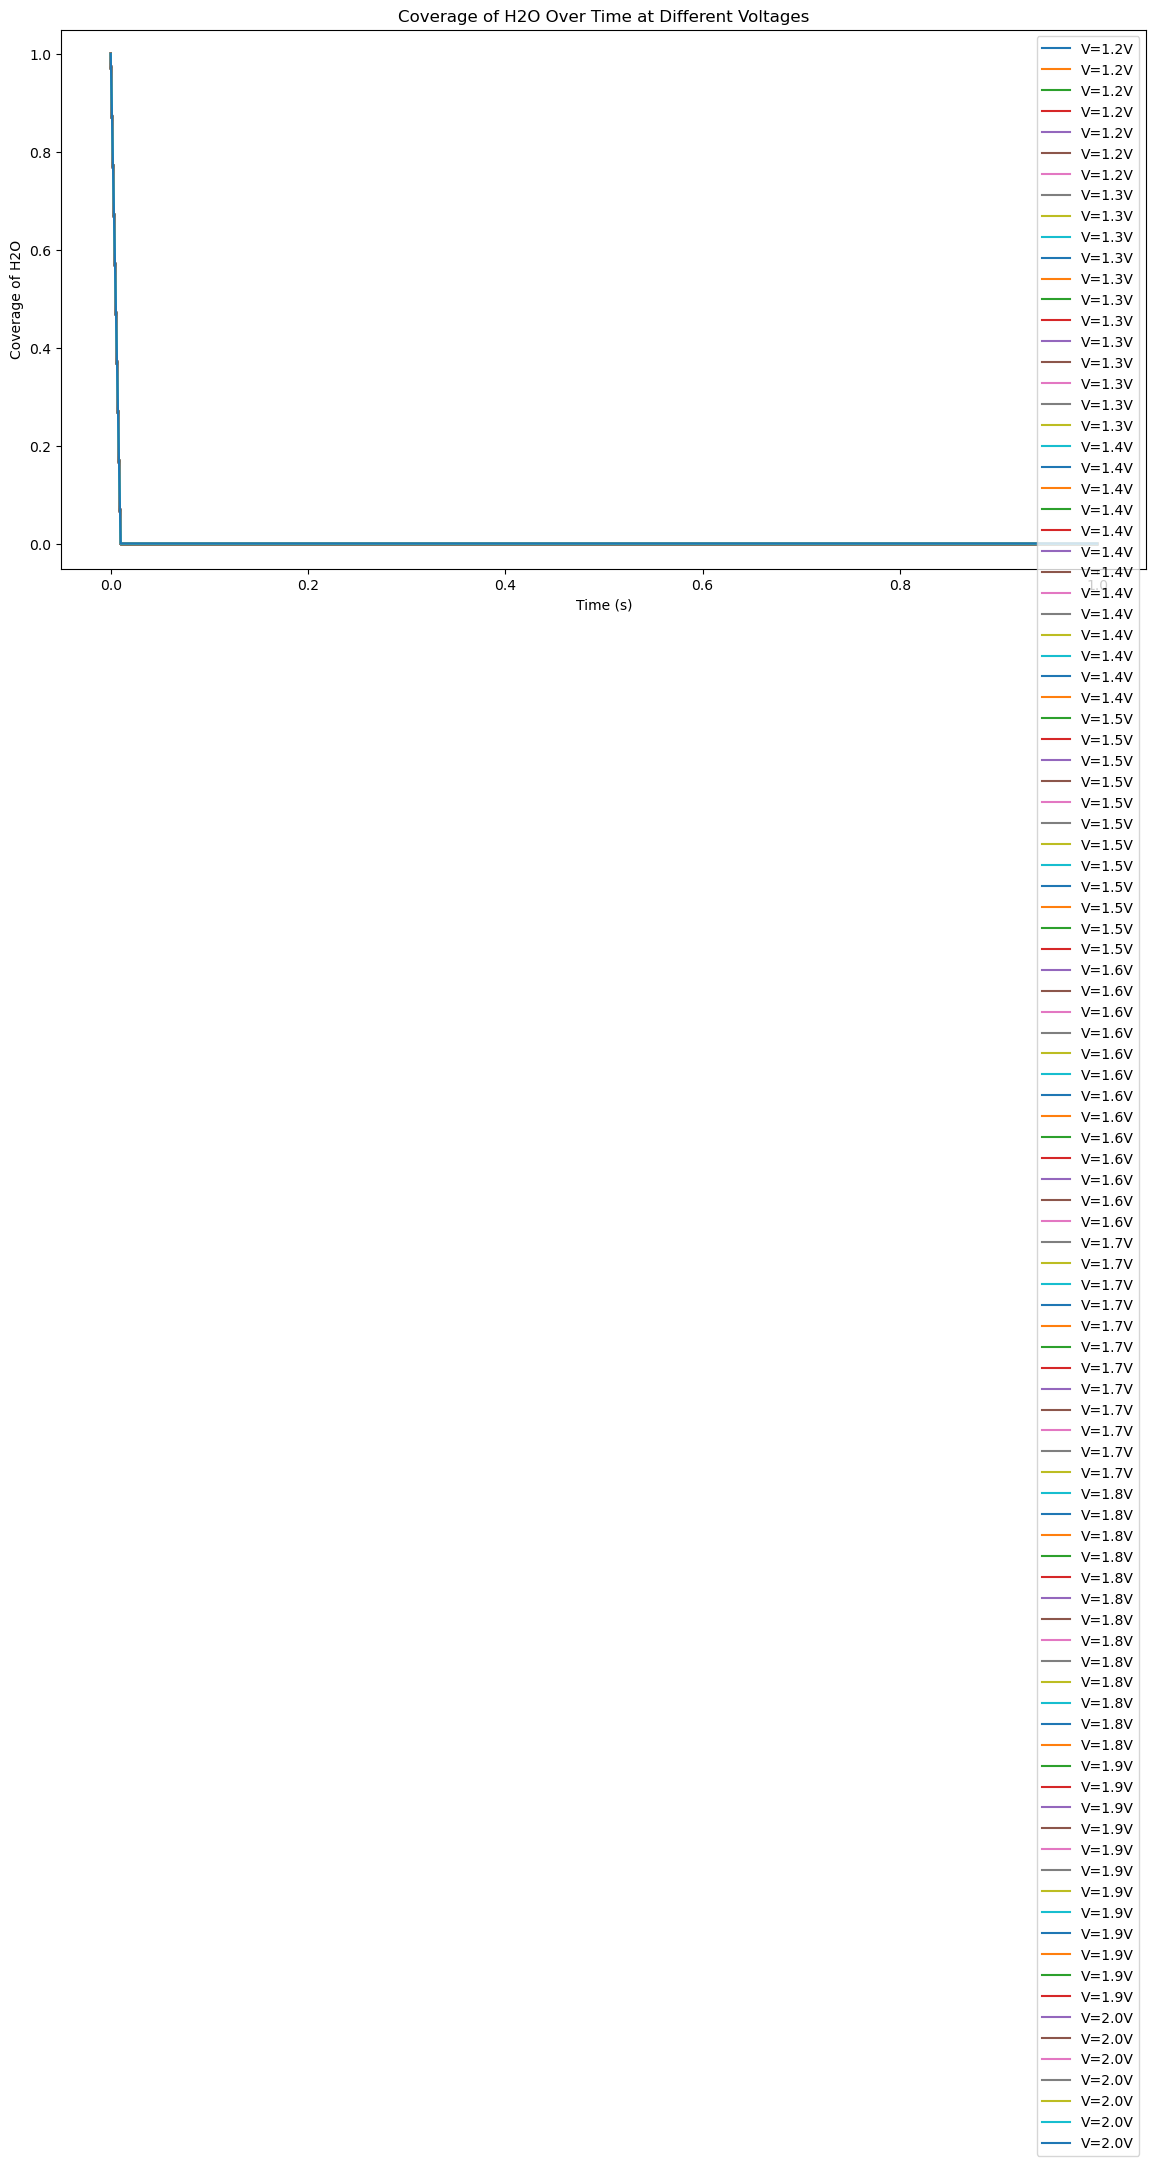

In [10]:
plt.figure(figsize=(14, 7))
for i, V in enumerate(voltage_range):
    plt.plot(time_range, theta_time_results[i][:, 0], label=f'V={V:.1f}V')
plt.xlabel('Time (s)')
plt.ylabel('Coverage of H2O')
plt.title('Coverage of H2O Over Time at Different Voltages')
plt.legend()
plt.show()

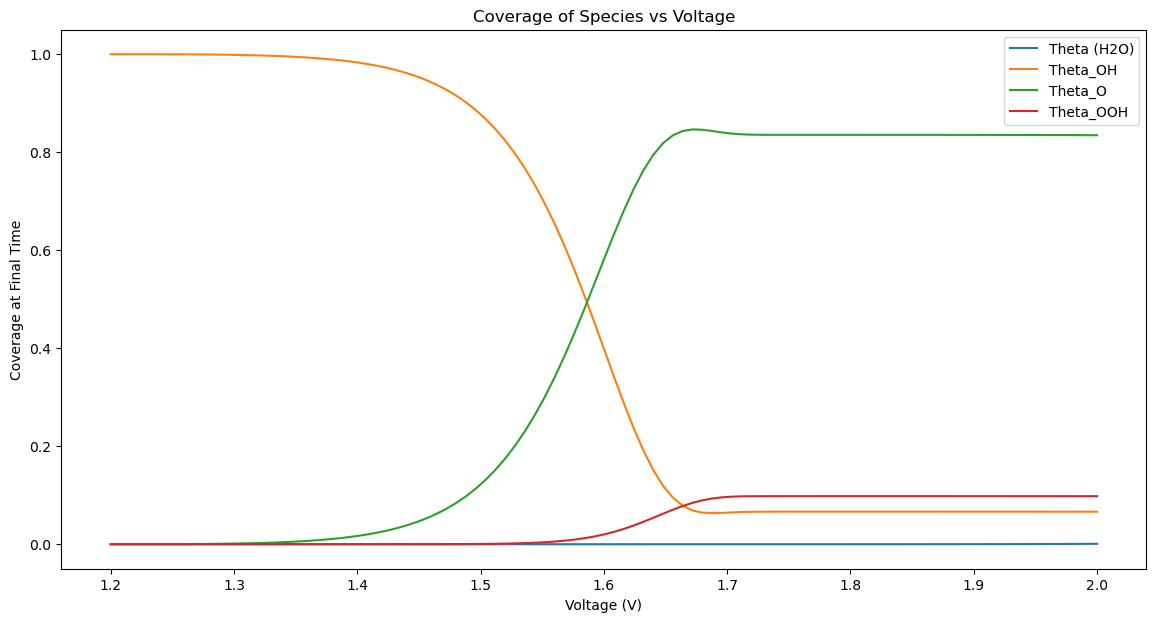

In [11]:
theta_voltage_results = np.array(theta_voltage_results)
plt.figure(figsize=(14, 7))
plt.plot(voltage_range, theta_voltage_results[:, 0], label='Theta (H2O)')
plt.plot(voltage_range, theta_voltage_results[:, 1], label='Theta_OH')
plt.plot(voltage_range, theta_voltage_results[:, 2], label='Theta_O')
plt.plot(voltage_range, theta_voltage_results[:, 3], label='Theta_OOH')
plt.xlabel('Voltage (V)')
plt.ylabel('Coverage at Final Time')
plt.title('Coverage of Species vs Voltage')
plt.legend()
plt.show()

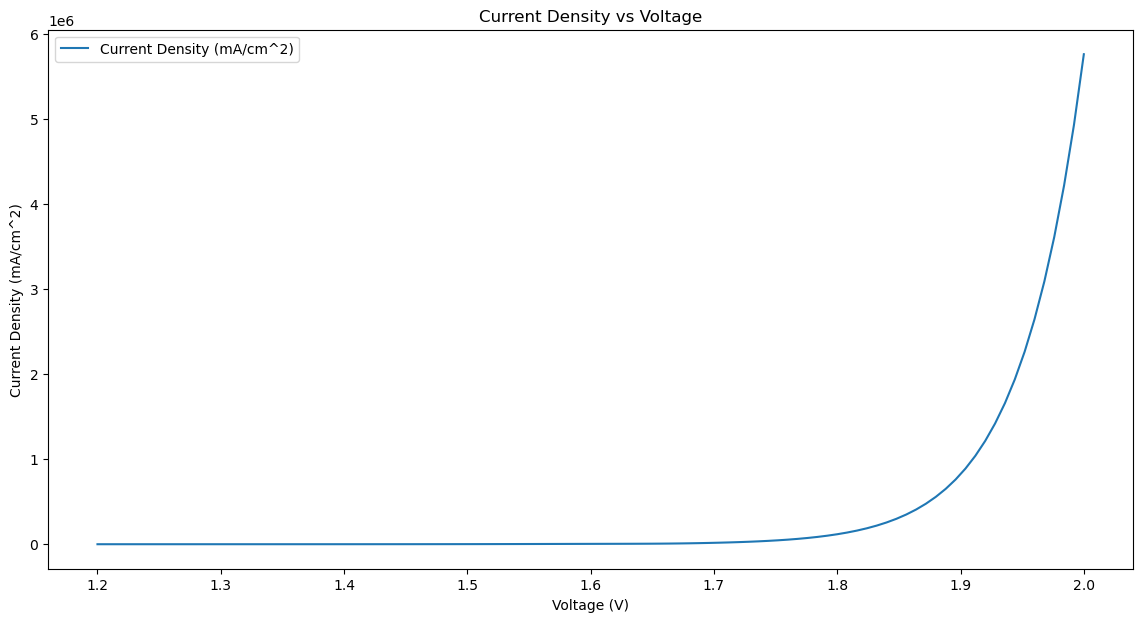

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(voltage_range, j_values_mA_cm2, label='Current Density (mA/cm^2)')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (mA/cm^2)')
plt.title('Current Density vs Voltage')
plt.legend()
plt.show()


In [13]:
data = {
    'Voltage (V)': voltage_range,
    'Current Density (mA/cm^2)': j_values_mA_cm2
}
df = pd.DataFrame(data)

# Specify the file path, including the file name and .xlsx extension
excel_filepath = r'F:\桌面\阶段汇报\多尺度模拟文件夹\jV_dataruO2_13.xlsx'

# Output the DataFrame to an Excel file
df.to_excel(excel_filepath, index=False)

print(f'Data has been written to {excel_filepath}')

Data has been written to F:\桌面\阶段汇报\多尺度模拟文件夹\jV_dataruO2_13.xlsx
